In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 使用 CPU
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Using TensorFlow backend.


Load data

In [2]:
filenames = os.listdir("./final-exam-data/data/kaggle_dogcat/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


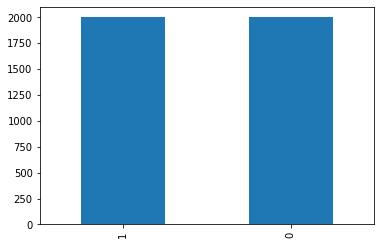

In [3]:
df['category'].value_counts().plot.bar()

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.regularizers import l1, l2, l1_l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
l2_ratio=1e-4
model.add(Dense(2, activation='softmax', kernel_regularizer=l2(l2_ratio))) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

W0818 10:16:54.611981  2016 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 10:16:54.629984  2016 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 10:16:54.633950  2016 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 10:16:54.658948  2016 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0818 10:16:54.659964  2016 deprecation_wrapper.py:1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [7]:
df["category"] = df["category"].replace({1: 'cat', 0: 'dog'}) 

In [8]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [9]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size= 40

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=24,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./final-exam-data/data/kaggle_dogcat/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3200 validated image filenames belonging to 2 classes.


In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./final-exam-data/data/kaggle_dogcat/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 2 classes.


In [12]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./final-exam-data/data/kaggle_dogcat/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


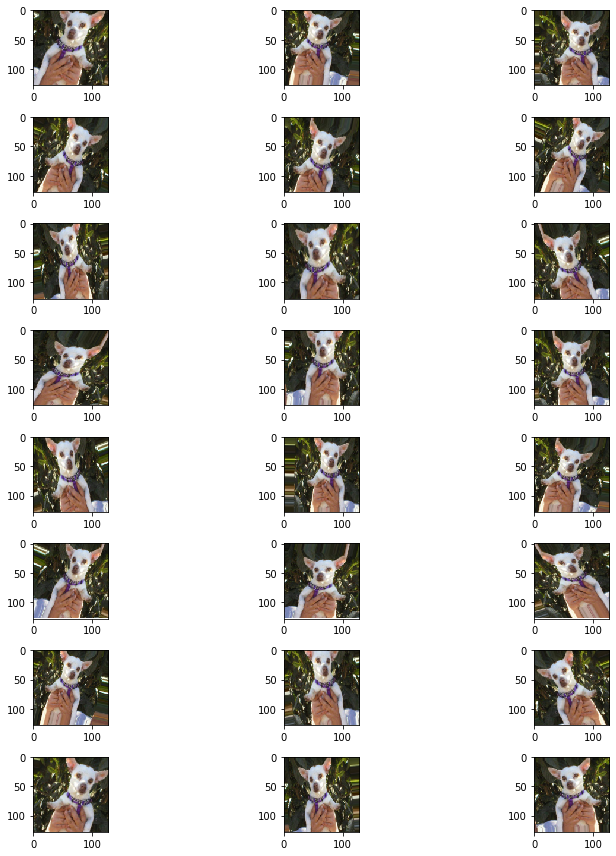

In [13]:
plt.figure(figsize=(12, 12))
for i in range(0, 24):
    plt.subplot(8, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [14]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

W0818 10:16:59.518982  2016 deprecation.py:323] From C:\Users\Julian\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
80/80 [==============================] - 17s 209ms/step - loss: 1.1646 - acc: 0.5719 - val_loss: 1.1732 - val_acc: 0.5625
Epoch 2/50
80/80 [==============================] - 15s 186ms/step - loss: 0.8351 - acc: 0.6122 - val_loss: 0.7120 - val_acc: 0.6813
Epoch 3/50
80/80 [==============================] - 15s 186ms/step - loss: 0.7460 - acc: 0.6309 - val_loss: 0.5971 - val_acc: 0.7075
Epoch 4/50
80/80 [==============================] - 15s 187ms/step - loss: 0.6572 - acc: 0.6462 - val_loss: 0.6587 - val_acc: 0.6913
Epoch 5/50
80/80 [==============================] - 15s 186ms/step - loss: 0.6193 - acc: 0.6809 - val_loss: 0.7062 - val_acc: 0.6112

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
80/80 [==============================] - 15s 186ms/step - loss: 0.5554 - acc: 0.7041 - val_loss: 0.4673 - val_acc: 0.7875
Epoch 7/50
80/80 [==============================] - 15s 187ms/step - loss: 0.5292 - acc: 0.7316 - val_loss: 0.4722 - val_

In [15]:
model.save_weights("model.h5")

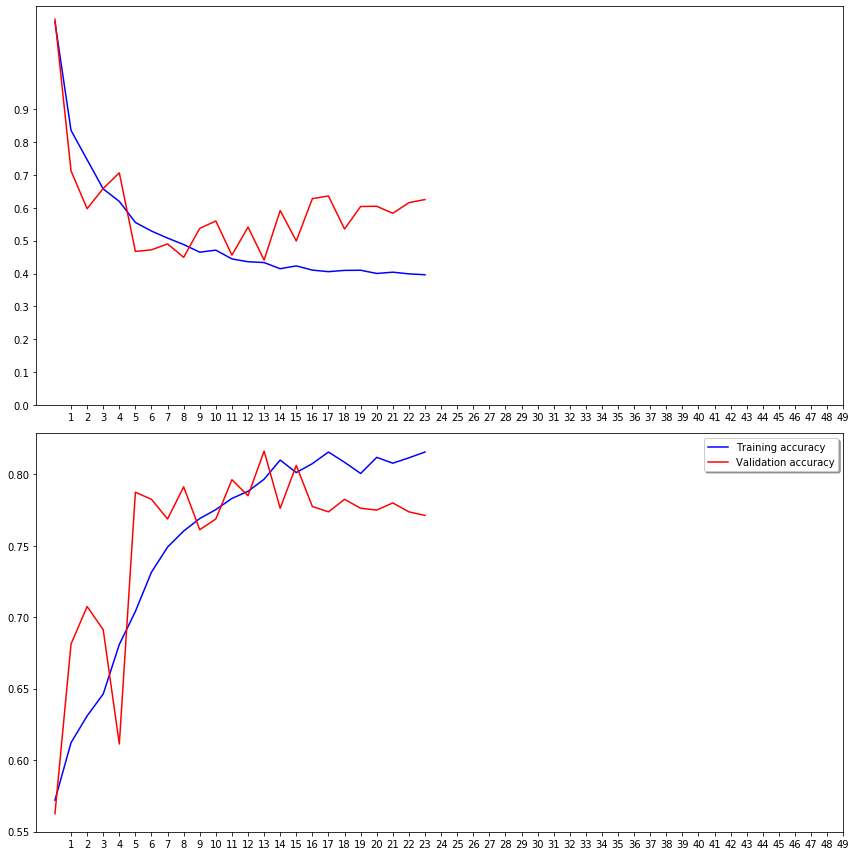

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Prepare Testing data

In [17]:
test_filenames = os.listdir("./final-exam-data/data/kaggle_dogcat/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [18]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./final-exam-data/data/kaggle_dogcat/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 400 validated image filenames.


Predict

In [19]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
predict

array([[4.84216154e-01, 5.15783846e-01],
       [9.32425082e-01, 6.75748959e-02],
       [9.95966673e-01, 4.03337413e-03],
       [1.34133985e-02, 9.86586571e-01],
       [9.98095095e-01, 1.90496142e-03],
       [9.41189349e-01, 5.88105954e-02],
       [2.51579136e-01, 7.48420894e-01],
       [8.59708846e-01, 1.40291154e-01],
       [9.99858618e-01, 1.41382101e-04],
       [9.88587379e-01, 1.14126410e-02],
       [1.87896173e-02, 9.81210411e-01],
       [9.99779880e-01, 2.20145346e-04],
       [6.17058337e-01, 3.82941633e-01],
       [9.99965072e-01, 3.49666880e-05],
       [9.86697495e-01, 1.33024585e-02],
       [4.51240271e-01, 5.48759758e-01],
       [1.20217283e-03, 9.98797774e-01],
       [9.99909520e-01, 9.04682602e-05],
       [8.00129950e-01, 1.99870080e-01],
       [9.88525987e-01, 1.14739388e-02],
       [9.96258497e-01, 3.74148856e-03],
       [9.58318114e-01, 4.16818336e-02],
       [4.84517753e-01, 5.15482187e-01],
       [1.00000000e+00, 1.86409066e-09],
       [9.999511

In [20]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df['category']=predict[:,0]
test_df['category']

0      0.484216
1      0.932425
2      0.995967
3      0.013413
4      0.998095
5      0.941189
6      0.251579
7      0.859709
8      0.999859
9      0.988587
10     0.018790
11     0.999780
12     0.617058
13     0.999965
14     0.986697
15     0.451240
16     0.001202
17     0.999910
18     0.800130
19     0.988526
20     0.996258
21     0.958318
22     0.484518
23     1.000000
24     0.999951
25     0.838508
26     0.684492
27     0.867544
28     0.914403
29     0.177736
         ...   
370    0.931551
371    0.986594
372    0.979570
373    0.944821
374    0.999252
375    0.056544
376    0.358492
377    0.935180
378    0.343856
379    0.851600
380    0.352052
381    0.424231
382    0.815731
383    0.999978
384    0.999980
385    0.031613
386    0.035163
387    0.019101
388    0.015533
389    0.450536
390    0.547327
391    0.077211
392    0.593957
393    0.999672
394    0.025261
395    0.232102
396    0.996953
397    0.999957
398    0.999962
399    0.999863
Name: category, Length: 

In [21]:
# label_map = dict((v,k) for k,v in train_generator.class_indices.items())
# test_df['category'] = test_df['category'].replace(label_map)

In [22]:
# test_df['category'] = test_df['category'].replace({ 'dog': 0, 'cat': 1 })

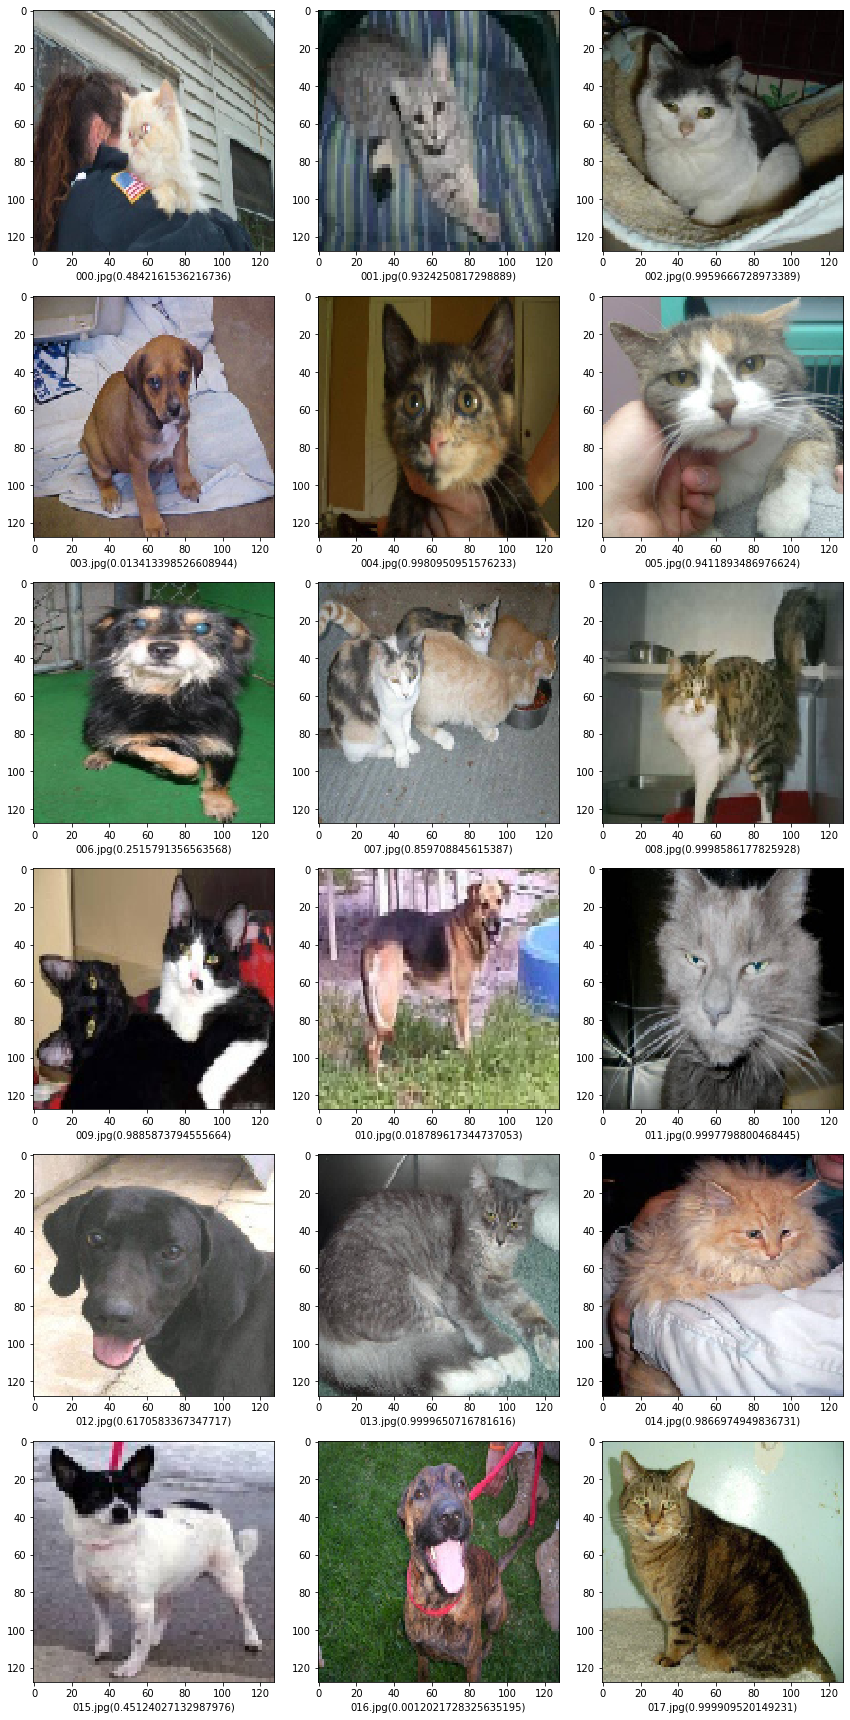

In [23]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./final-exam-data/data/kaggle_dogcat/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [24]:
submission_df = test_df.copy()
submission_df['ID'] = submission_df['filename'].str.split('.').str[0]
submission_df['Predicted'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)